In [1]:
import os
from glob import glob

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import cv2 as cv

In [2]:
data_dir = "../input/best-artworks-of-all-time"
image_dir = "../input/best-artworks-of-all-time/resized/resized"
image_root = "../input/best-artworks-of-all-time/resized"

Sample Arts


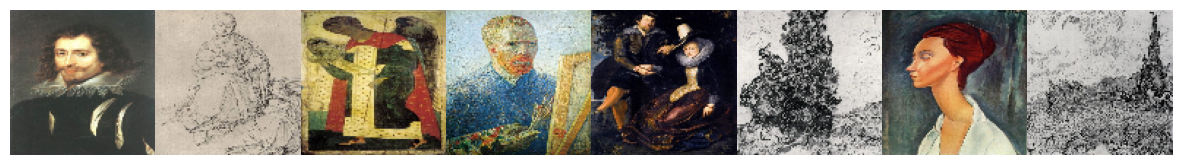

In [3]:
no_plots = 8*1
images = glob(f'{image_dir}/*')

plt.rcParams['figure.figsize'] = (15, 15)
plt.subplots_adjust(wspace=0, hspace=0)

print("Sample Arts")
for idx,image in enumerate(images[:no_plots]):
    sample_img = cv.imread(image)
    sample_img = cv.resize(sample_img,(100,100))
    plt.subplot(1, 8, idx+1)
    plt.axis('off')
    plt.imshow(cv.cvtColor(sample_img,cv.COLOR_BGR2RGB))
plt.show()

In [4]:
import torch
from torchvision import datasets
from torchvision import transforms

# helper display function
def tensor_imshow(img,dnorm=True):
    img = img.to('cpu')
    npimg = img.detach().numpy()
    if dnorm:
        npimg = npimg*0.5+0.5
    plt.figure(figsize=(3, 3))
    plt.axis('off')
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [5]:
def get_dataloader(batch_size,image_size,data_dir=image_dir,num_workers=3):
    stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
    transform = transforms.Compose([
        transforms.Resize((image_size,image_size)),
        transforms.ToTensor(),
        # We tranform our image values to be between -1 and 1 (the range of the tanh activation)
        transforms.Normalize(*stats), # 
    ])
    
    dataset = datasets.ImageFolder(root=data_dir,transform=transform)
    
    data_loader = torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
    )
    
    return data_loader

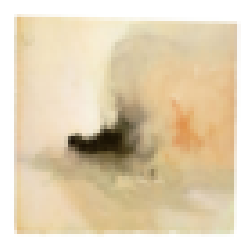

In [6]:
# Testing the dataloader
batch_size, image_size = 8, 64
train_loader = get_dataloader(batch_size,image_size,image_root)
dataiter = iter(train_loader)

img,_ = next(dataiter)
sample_img = img[-1]
tensor_imshow(sample_img)

In [7]:
import torch.nn as nn
import torch.nn.functional as F

In [8]:
class Generator(nn.Module):
    def __init__(self,z_dim=10,in_chan=3,hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        self.in_chan = in_chan
        self.hidden_dim = hidden_dim
        
        self.generator = nn.Sequential(
            self.make_gen_block(z_dim,512,stride=1,padding=0,),
            self.make_gen_block(512,256),
            self.make_gen_block(256,128),
            self.make_gen_block(128,64),
            self.make_gen_block(64,32),
            self.make_gen_block(32, in_chan,final_layer=True),
        )
    
    def make_gen_block(self,in_channels,op_channels,kernel_size=4,stride=2,padding=1,final_layer=False):
        layers = []
        layers.append(nn.ConvTranspose2d(in_channels,op_channels,kernel_size,stride,padding,bias=False))
        
        if not final_layer:
            layers.append(nn.BatchNorm2d(op_channels))
            layers.append(nn.LeakyReLU(0.2))
        else:
            layers.append(nn.Tanh())
        
        return nn.Sequential(*layers)
    
    def forward(self,noise):
        x = noise.view(-1,self.z_dim,1,1)
        return self.generator(x)

    def get_noise(n_samples, z_dim, device='cpu'):
        return torch.randn(n_samples, z_dim, device=device)

In [9]:
#Testing Genarator
noise = Generator.get_noise(n_samples=5,z_dim=10)
g = Generator(z_dim=10,in_chan=3,hidden_dim=64)
# print(g)
img = g(noise)
print(img.shape)
assert img.shape == (5,3,128,128), "Generator Output Images shape incorrect"
print("Generator Test passed!!")

torch.Size([5, 3, 128, 128])
Generator Test passed!!


In [10]:
class Discriminator(nn.Module):
    def __init__(self,im_chan=3,conv_dim=64,image_size=64):
        super(Discriminator, self).__init__()
        self.image_size = image_size
        self.conv_dim = conv_dim
        
        self.disc_cnn = nn.Sequential(
            self.make_disc_block(3,32),
            self.make_disc_block(32,64),
            self.make_disc_block(64,128),
            self.make_disc_block(128,256),
            self.make_disc_block(256,512),
            self.make_disc_block(512,1,padding=0,final_layer=True),
        )
        
        
    def make_disc_block(self,in_chan,op_chan,kernel_size=4,stride=2,padding=1,final_layer=False):
        layers = []
        layers.append(nn.Conv2d(in_chan,op_chan,kernel_size,stride,padding,bias=False))
        
        if not final_layer:
            layers.append(nn.BatchNorm2d(op_chan))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
        
        return nn.Sequential(*layers)
    
    
    def forward(self,image):
        pred = self.disc_cnn(image)
        pred = pred.view(image.size(0),-1)
        return pred
    
    def _get_final_feature_dimention(self):
        final_width_height = (self.image_size //  2**len(self.disc_cnn))**2
        final_depth = self.conv_dim * 2**(len(self.disc_cnn)-1)
        return final_depth*final_width_height

In [11]:
#Testing Discriminator
d = Discriminator(im_chan=3,conv_dim=128,image_size=64)
# print(d)
img = torch.rand(4,3,128,128)
d_op = d(img)
assert d_op.shape == (4,1),"Discrimenator Output Images shape incorrect"
print("Discrimenator test passed!!")

Discrimenator test passed!!


In [12]:
def weights_init_normal(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)

In [13]:
def real_loss(D_out,device='cpu'):
    criterion = nn.BCEWithLogitsLoss()
    batch_size = D_out.size(0)
    labels = torch.ones(batch_size,device=device)*0.9 # real labels = 1 and lable smoothing => 0.9
    
    loss = criterion(D_out.squeeze(),labels)
    return loss

def fake_loss(D_out,device='cpu'):
    criterion = nn.BCEWithLogitsLoss()
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size,device=device) # fake labels = 0
    
    loss = criterion(D_out.squeeze(),labels)
    return loss

In [14]:
def print_tensor_images(images_tensor):
    plt.rcParams['figure.figsize'] = (15, 15)
    plt.subplots_adjust(wspace=0, hspace=0)
    
    images_tensor = images_tensor.to('cpu')
    npimgs = images_tensor.detach().numpy()
    
    no_plots = len(images_tensor)

    for idx,image in enumerate(npimgs):
        plt.subplot(1, 8, idx+1)
        plt.axis('off')
        #dnorm
        image = image * 0.5 + 0.5
        plt.imshow(np.transpose(image, (1, 2, 0)))
    plt.show()

def train(D, G, n_epochs,dataloader,d_optimizer,g_optimizer,z_dim,print_every=50,device='cpu'):
    
    ## Get some fixed data for sampling.##      
    sample_size=8
    fixed_z = Generator.get_noise(n_samples=sample_size,z_dim=z_dim,device=device)
    
    for epoch in range(1,n_epochs+1):
        for batch_i,(real_images,_) in enumerate(dataloader):
            batch_size = real_images.size(0)
            real_images = real_images.to(device)
            
            ### Discriminator part ###
            d_optimizer.zero_grad()
            
            #loss on real image
            d_real_op = D(real_images)
            d_real_loss = real_loss(d_real_op,device=device)
            
            #loss on fake image
            noise = Generator.get_noise(n_samples=batch_size,z_dim=z_dim,device=device)
            fake_images = G(noise)
            d_fake_op = D(fake_images)
            d_fake_loss = fake_loss(d_fake_op,device=device)
            
            #total loss
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step()
            
            ### Generator part ###
            g_optimizer.zero_grad()
            noise = Generator.get_noise(n_samples=batch_size,z_dim=z_dim,device=device)
            g_out = G(noise)
            d_out = D(g_out)
            
            g_loss = real_loss(d_out,device=device)
            g_loss.backward()
            g_optimizer.step()
        
        
        print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                    epoch, n_epochs, d_loss.item(), g_loss.item()))
        if (epoch % print_every == 0):
            G.eval()
            sample_image = G(fixed_z)
            print_tensor_images(sample_image)
            G.train()

In [15]:
import torch.optim as optim

In [16]:
# heperparams
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device is ",device)

z_dim = 150
beta_1 = 0.5
beta_2 = 0.999 

n_epochs = 150
lr = 0.0002

batch_size = 128
image_size = 128

Device is  cpu


In [17]:
# model init
gen = Generator(z_dim,in_chan=3,hidden_dim=64).to(device)
disc = Discriminator(im_chan=3,conv_dim=64,image_size=image_size).to(device)


# optimizer init
g_optimizer = optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))
d_optimizer = optim.Adam(disc.parameters(), lr=lr, betas=(beta_1, beta_2))

dataloader = get_dataloader(batch_size,image_size,image_root)

Epoch [    1/   30] | d_loss: 0.5433 | g_loss: 3.5963
Epoch [    2/   30] | d_loss: 0.7361 | g_loss: 2.5710
Epoch [    3/   30] | d_loss: 0.7856 | g_loss: 1.8069
Epoch [    4/   30] | d_loss: 0.9209 | g_loss: 2.8599
Epoch [    5/   30] | d_loss: 1.1802 | g_loss: 4.3119
Epoch [    6/   30] | d_loss: 0.6086 | g_loss: 2.8497
Epoch [    7/   30] | d_loss: 0.6542 | g_loss: 3.2176
Epoch [    8/   30] | d_loss: 0.8150 | g_loss: 3.3892
Epoch [    9/   30] | d_loss: 0.7001 | g_loss: 2.6508
Epoch [   10/   30] | d_loss: 0.7808 | g_loss: 3.0543


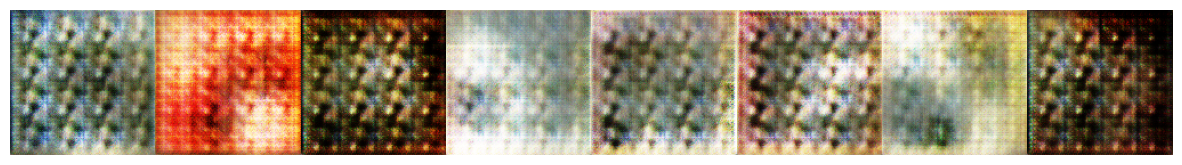

Epoch [   11/   30] | d_loss: 1.4782 | g_loss: 0.9289
Epoch [   12/   30] | d_loss: 1.4138 | g_loss: 4.3321
Epoch [   13/   30] | d_loss: 1.0548 | g_loss: 1.6221
Epoch [   14/   30] | d_loss: 0.9183 | g_loss: 3.1213
Epoch [   15/   30] | d_loss: 0.7090 | g_loss: 2.5987
Epoch [   16/   30] | d_loss: 0.8695 | g_loss: 3.1397
Epoch [   17/   30] | d_loss: 0.6961 | g_loss: 3.3572
Epoch [   18/   30] | d_loss: 0.8387 | g_loss: 1.8836
Epoch [   19/   30] | d_loss: 0.6048 | g_loss: 2.1267
Epoch [   20/   30] | d_loss: 0.6047 | g_loss: 3.2309


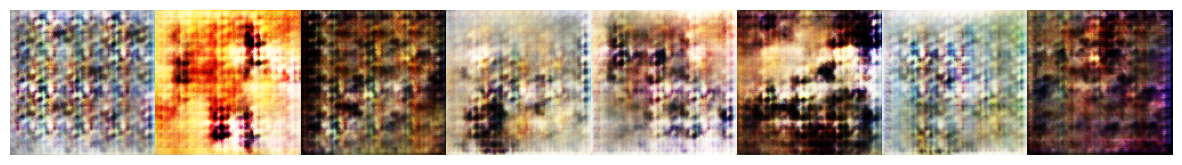

Epoch [   21/   30] | d_loss: 0.8579 | g_loss: 1.4213
Epoch [   22/   30] | d_loss: 0.7129 | g_loss: 3.4939
Epoch [   23/   30] | d_loss: 0.9567 | g_loss: 2.6501
Epoch [   24/   30] | d_loss: 0.8597 | g_loss: 2.1570
Epoch [   25/   30] | d_loss: 0.6386 | g_loss: 3.0216
Epoch [   26/   30] | d_loss: 1.0614 | g_loss: 4.0418
Epoch [   27/   30] | d_loss: 0.5309 | g_loss: 2.8726
Epoch [   28/   30] | d_loss: 0.9892 | g_loss: 4.8726
Epoch [   29/   30] | d_loss: 1.3281 | g_loss: 1.9213
Epoch [   30/   30] | d_loss: 0.5871 | g_loss: 2.6131


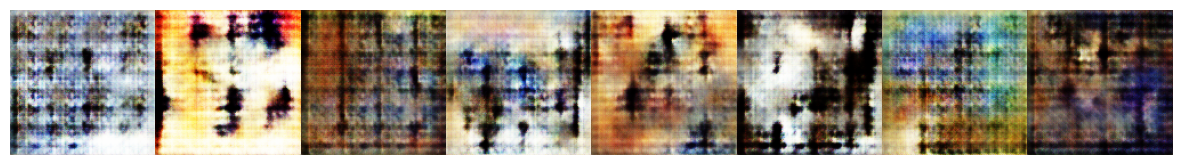

In [18]:
n_epochs = 30
train(
    disc,gen,
    n_epochs,dataloader,
    d_optimizer,g_optimizer,
    z_dim,
    print_every=10,
    device=device,
)

In [19]:
def save_model(gen,file_name):
    gen = gen.to('cpu')
    torch.save(gen.state_dict(),"gen_128_epoch_350.pth")

save_model(gen,"kaggle")

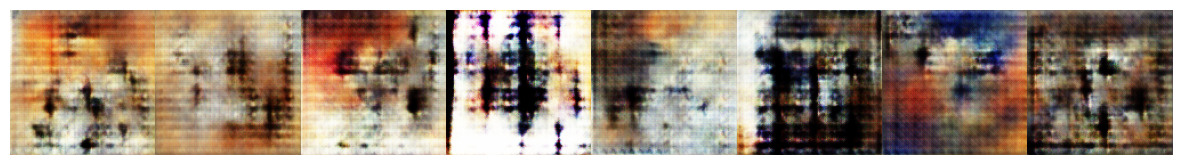

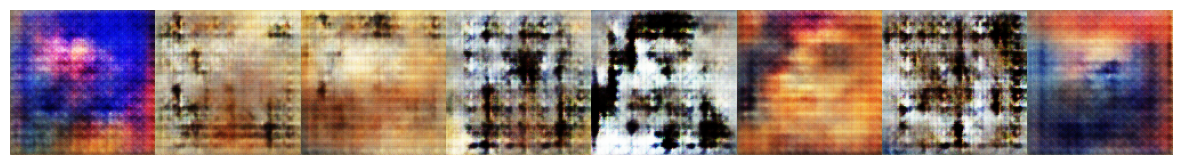

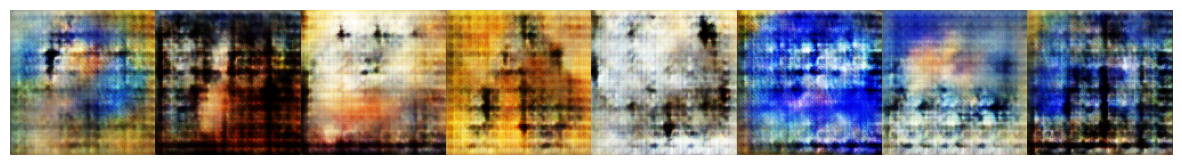

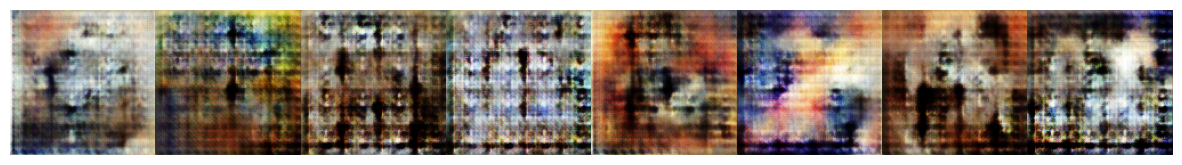

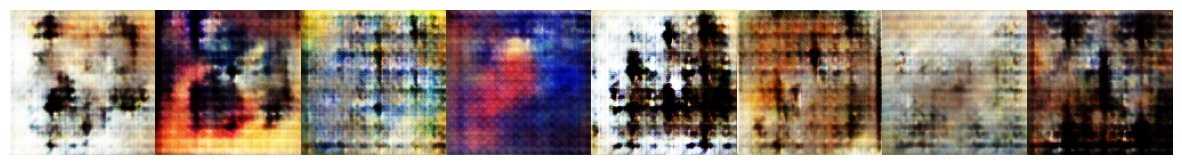

In [20]:
#sample generation
gen.to(device)
gen.eval()
sample_size=8
for i in range(5):
    fixed_z = Generator.get_noise(n_samples=sample_size,z_dim=z_dim,device=device)    
    sample_image = gen(fixed_z)
    print_tensor_images(sample_image)